<a href="https://colab.research.google.com/github/kasaiannn/HW/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/drive/1tElT3FhddabqCyJKFH27rhnyXJTqrzke?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework

The quality of classification/regression by the k Nearest Neighbors method depends on several parameters:
* the number of neighbors `n_neighbors`
* the distance metric between objects `metric`
* the weights of neighbors (the neighbors of the test example can enter with different weights, for example, the further the example, the less its "voice" is taken into account) `weights`


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Загрузка данных
all_data = pd.read_csv('forest_dataset.csv')

# Разделение на признаки и метки классов
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

# Разделение на обучающую и тестовую выборки
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42)

Train the `KNeighborsClassifier` on the dataset.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Создание классификатора KNN
clf = KNeighborsClassifier()

Let's select the parameters of our model:

* Iterate over the grid from `1` to `10` for the number of neighbors parameter
* Also, try using different metrics: `['manhattan', 'euclidean']`
* Try using different weight calculation strategies: `[‘uniform’, ‘distance’]`

In [7]:
from sklearn.model_selection import GridSearchCV
# Параметры для перебора
params = {
    'n_neighbors': range(1, 11),
    'metric': ['manhattan', 'euclidean'],
    'weights': ['uniform', 'distance']
}

# Поиск по сетке параметров
clf_grid = GridSearchCV(clf, params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(train_feature_matrix, train_labels);


Let's output the best parameters

In [8]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

Using the optimal number of neighbors found, calculate the probabilities of belonging to classes for the test sample (`.predict_proba`).

In [9]:
optimal_clf = clf_grid.best_estimator_
# Обучаем модель
optimal_clf.fit(train_feature_matrix, train_labels)
# Рассчитываем вероятности для тестовой выборки
pred_prob = optimal_clf.predict_proba(test_feature_matrix)


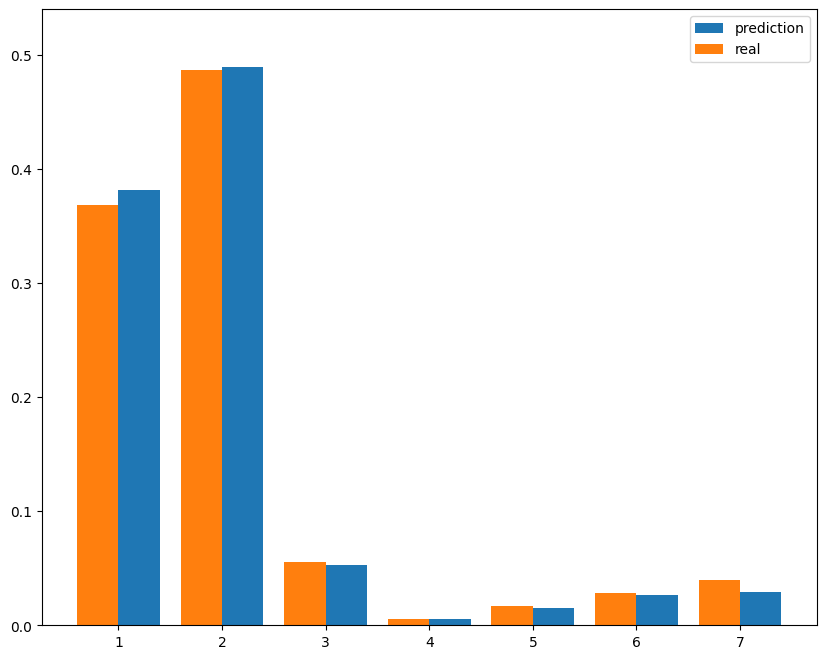

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

unique, freq = np.unique(test_labels, return_counts=True)
freq = list(map(lambda x: x / len(test_labels),freq))

pred_freq = pred_prob.mean(axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
plt.ylim(0, 0.54)
plt.legend()
plt.show()

## Conclusion

What is the quality of the model on the test sample? Compare it with the quality of logistic regression. Which model is better? Why? What are the pros and cons of the k Nearest Neighbors method? Plot the ROC curve for the k Nearest Neighbors method. Calculate the area under the ROC curve (AUC-ROC).

In [12]:
from sklearn.metrics import accuracy_score

# Предсказания на тестовой выборке
y_pred = clf_grid.predict(test_feature_matrix)

# Точность классификации
accuracy = accuracy_score(test_labels, y_pred)
print(f"Точность KNN на тестовой выборке: {accuracy:.4f}")

#Сравнение с логистической регрессией
#Обучим модель логистической регрессии для сравнения:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_feature_matrix)
X_test_scaled = scaler.transform(test_feature_matrix)

# Создаем и обучаем модель
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, train_labels)

# Оцениваем качество
accuracy = model.score(X_test_scaled, test_labels)
print(f"Точность логистической регрессии на тестовой выборке: {accuracy:.4f}")

Точность KNN на тестовой выборке: 0.7845
Точность логистической регрессии на тестовой выборке: 0.7180


###  

KNN показал точность **78.45%**, а логистическая регрессия — **71.80%**. То есть KNN работает немного лучше.  

**Почему KNN лучше?**  
- Он учитывает сложные зависимости в данных, а логистическая регрессия пытается провести простое линейное разделение, что не всегда подходит.  
- KNN не делает строгих предположений о данных, поэтому может работать лучше, если классы сложно разделить.  

**Но у KNN есть минусы:**  
- Он медленный на больших данных, потому что хранит всю обучающую выборку.  
- Чувствителен к шумам и требует подбора параметров (например, числа соседей).  

**Логистическая регрессия проигрывает, но у неё есть плюсы:**  
- Быстрее работает, особенно на больших данных.  
- Её проще интерпретировать.  

**Вывод:**  
Если важна точность и данные сложные — лучше KNN. Если нужна скорость и простота — можно попробовать улучшить логистическую регрессию. В целом, выбор модели зависит от задачи и данных.

# ROC curve и AUC-ROC

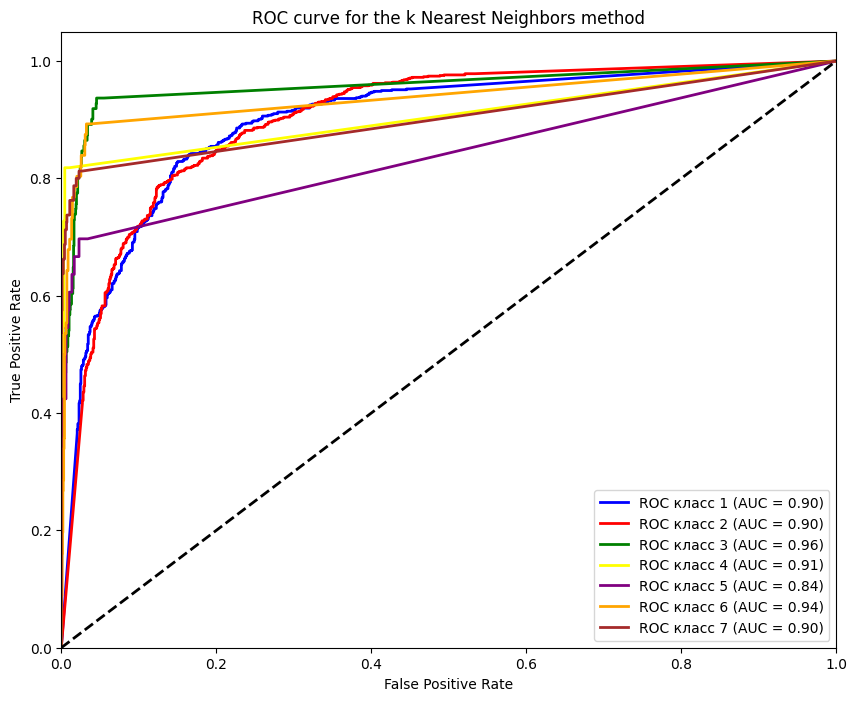

Средний AUC-ROC: 0.9063452430548241


In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Бинаризация меток для многоклассовой классификации
y_test_bin = label_binarize(test_labels, classes=[1, 2, 3, 4, 5, 6, 7])
n_classes = y_test_bin.shape[1]

# Вычисление ROC-кривой и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC класс {0} (AUC = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for the k Nearest Neighbors method')
plt.legend(loc="lower right")
plt.show()

# Средний AUC
print("Средний AUC-ROC:", np.mean(list(roc_auc.values())))